# 1. MODEL

In [58]:
import torch.nn as nn
import torch as t
import torch.nn.functional as F
import math
import numpy as np
import copy
from collections import OrderedDict

def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

class Linear(nn.Module):
    """
    Linear Module
    """
    def __init__(self, in_dim, out_dim, bias=True, w_init='linear'):
        """
        :param in_dim: dimension of input
        :param out_dim: dimension of output
        :param bias: boolean. if True, bias is included.
        :param w_init: str. weight inits with xavier initialization.
        """
        super(Linear, self).__init__()
        self.linear_layer = nn.Linear(in_dim, out_dim, bias=bias)

        nn.init.xavier_uniform_(
            self.linear_layer.weight,
            gain=nn.init.calculate_gain(w_init))

    def forward(self, x):
        return self.linear_layer(x)


class Conv(nn.Module):
    """
    Convolution Module
    """
    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1,
                 padding=0, dilation=1, bias=True, w_init='linear'):
        """
        :param in_channels: dimension of input
        :param out_channels: dimension of output
        :param kernel_size: size of kernel
        :param stride: size of stride
        :param padding: size of padding
        :param dilation: dilation rate
        :param bias: boolean. if True, bias is included.
        :param w_init: str. weight inits with xavier initialization.
        """
        super(Conv, self).__init__()

        self.conv = nn.Conv1d(in_channels, out_channels,
                              kernel_size=kernel_size, stride=stride,
                              padding=padding, dilation=dilation,
                              bias=bias)

        nn.init.xavier_uniform_(
            self.conv.weight, gain=nn.init.calculate_gain(w_init))

    def forward(self, x):
        x = self.conv(x)
        return x

class CBHG(nn.Module):
    """
    CBHG Module
    """
    def __init__(self, hidden_size, K=16, projection_size = 256, num_gru_layers=2, max_pool_kernel_size=2, is_post=False):
        """
        :param hidden_size: dimension of hidden unit
        :param K: # of convolution banks
        :param projection_size: dimension of projection unit
        :param num_gru_layers: # of layers of GRUcell
        :param max_pool_kernel_size: max pooling kernel size
        :param is_post: whether post processing or not
        """
        super(CBHG, self).__init__()
        self.hidden_size = hidden_size
        self.projection_size = projection_size
        self.convbank_list = nn.ModuleList()
        self.convbank_list.append(nn.Conv1d(in_channels=projection_size,
                                                out_channels=hidden_size,
                                                kernel_size=1,
                                                padding=int(np.floor(1/2))))

        for i in range(2, K+1):
            self.convbank_list.append(nn.Conv1d(in_channels=hidden_size,
                                                out_channels=hidden_size,
                                                kernel_size=i,
                                                padding=int(np.floor(i/2))))

        self.batchnorm_list = nn.ModuleList()
        for i in range(1, K+1):
            self.batchnorm_list.append(nn.BatchNorm1d(hidden_size))

        convbank_outdim = hidden_size * K
        
        self.conv_projection_1 = nn.Conv1d(in_channels=convbank_outdim,
                                             out_channels=hidden_size,
                                             kernel_size=3,
                                             padding=int(np.floor(3 / 2)))
        self.conv_projection_2 = nn.Conv1d(in_channels=hidden_size,
                                               out_channels=projection_size,
                                               kernel_size=3,
                                               padding=int(np.floor(3 / 2)))
        self.batchnorm_proj_1 = nn.BatchNorm1d(hidden_size)

        self.batchnorm_proj_2 = nn.BatchNorm1d(projection_size)


        self.max_pool = nn.MaxPool1d(max_pool_kernel_size, stride=1, padding=1)
        self.highway = Highwaynet(self.projection_size)
        self.gru = nn.GRU(self.projection_size, self.hidden_size // 2, num_layers=num_gru_layers,
                          batch_first=True,
                          bidirectional=True)


    def _conv_fit_dim(self, x, kernel_size=3):
        if kernel_size % 2 == 0:
            return x[:,:,:-1]
        else:
            return x

    def forward(self, input_):

        input_ = input_.contiguous()
        batch_size = input_.size(0)
        total_length = input_.size(-1)

        convbank_list = list()
        convbank_input = input_

        # Convolution bank filters
        for k, (conv, batchnorm) in enumerate(zip(self.convbank_list, self.batchnorm_list)):
            convbank_input = t.relu(batchnorm(self._conv_fit_dim(conv(convbank_input), k+1).contiguous()))
            convbank_list.append(convbank_input)

        # Concatenate all features
        conv_cat = t.cat(convbank_list, dim=1)

        # Max pooling
        conv_cat = self.max_pool(conv_cat)[:,:,:-1]

        # Projection
        conv_projection = t.relu(self.batchnorm_proj_1(self._conv_fit_dim(self.conv_projection_1(conv_cat))))
        conv_projection = self.batchnorm_proj_2(self._conv_fit_dim(self.conv_projection_2(conv_projection))) + input_

        # Highway networks
        highway = self.highway.forward(conv_projection.transpose(1,2))
        

        # Bidirectional GRU
        
        self.gru.flatten_parameters()
        out, _ = self.gru(highway)

        return out


class Highwaynet(nn.Module):
    """
    Highway network
    """
    def __init__(self, num_units, num_layers=4):
        """
        :param num_units: dimension of hidden unit
        :param num_layers: # of highway layers
        """
        super(Highwaynet, self).__init__()
        self.num_units = num_units
        self.num_layers = num_layers
        self.gates = nn.ModuleList()
        self.linears = nn.ModuleList()
        for _ in range(self.num_layers):
            self.linears.append(Linear(num_units, num_units))
            self.gates.append(Linear(num_units, num_units))

    def forward(self, input_):

        out = input_

        # highway gated function
        for fc1, fc2 in zip(self.linears, self.gates):

            h = t.relu(fc1.forward(out))
            t_ = t.sigmoid(fc2.forward(out))

            c = 1. - t_
            out = h * t_ + out * c

        return out

class ModelPostNet(nn.Module):
    """
    CBHG Network (mel --> linear)
    """
    def __init__(self):
        super(ModelPostNet, self).__init__()
        self.pre_projection = Conv(80, 256)  # replaced hp.n_mels with 80 and hp.hidden_size with 256
        self.cbhg = CBHG(256)  # replaced hidden_size with 256
        self.post_projection = Conv(256, (800 // 2) + 1)  # replaced hp.n_fft with 2024 and hp.hidden_size with 256

    def forward(self, mel):
        mel = mel.transpose(1, 2)
        mel = self.pre_projection(mel)
        mel = self.cbhg(mel).transpose(1, 2)
        mag_pred = self.post_projection(mel).transpose(1, 2)

        return mag_pred

# 2. DATASET

In [2]:
MEL_DIR = "/kaggle/input/vlsp2020-fosd-mag-mel-transcript/mels"
MAG_DIR = "/kaggle/input/vlsp2020-fosd-mag-mel-transcript/mags"

In [2]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
import librosa

class MelMagDataset(Dataset):
    def __init__(self, audio_dir, transform=None, sr=16000, n_fft=2048, hop_length=int(16000 * 0.0125), n_mels=80, max_db=100, ref_db=20, fixed_length=None):
        """
        Args:
            audio_dir (str): Path to the directory containing audio .npy files.
            transform (callable, optional): Optional transform to apply to both mel and audio.
            sr (int): Sample rate of the audio files.
            n_fft (int): Number of FFT components.
            hop_length (int): Hop length for the STFT.
            n_mels (int): Number of mel filters.
            max_db (float): Maximum decibel level for normalization.
            ref_db (float): Reference decibel level for normalization.
            fixed_length (int, optional): If provided, audio will be padded or trimmed to this length in samples.
        """
        self.audio_dir = audio_dir
        self.transform = transform
        self.sr = sr
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.max_db = max_db
        self.ref_db = ref_db
        self.fixed_length = fixed_length  # If fixed length is given

        # Get a list of file names (without extensions)
        self.filenames = sorted([f[:-4] for f in os.listdir(MEL_DIR) if f.endswith('.npy')])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # # Load the audio file
        # audio_path = os.path.join(self.audio_dir, self.filenames[idx] + '.npy')
        # audio = np.load(audio_path)

        # # Handle audio padding or trimming if fixed length is set
        # if self.fixed_length is not None:
        #     audio = self._pad_or_trim_audio(audio)

        # # Generate mel and magnitude spectrograms
        # mel, mag = self.get_spectrograms(audio)

        # # Apply optional transform
        # if self.transform:
        #     mel, mag = self.transform(mel, mag)
        mel_path = os.path.join(MEL_DIR, self.filenames[idx] + '.npy')
        mag_path = os.path.join(MAG_DIR, self.filenames[idx] + '.npy')

        try:
            mel = np.load(mel_path)
        except:
            audio_path = os.path.join(self.audio_dir, self.filenames[idx] + '.npy')
            audio = np.load(audio_path)
            mel = self.audio_to_mel(audio)

        try:
            mag = np.load(mag_path)
        except:
            audio_path = os.path.join(self.audio_dir, self.filenames[idx] + '.npy')
            audio = np.load(audio_path)
            mag = self.audio_to_magnitude(audio)

        return {
            "mel": mel,
            "mag": mag
        }

    def _pad_or_trim_audio(self, audio):
        """
        Pad or trim the audio to a fixed length in samples.
        """
        target_length = self.fixed_length
        if len(audio) < target_length:
            # Pad audio if it's shorter than the target length
            audio = np.pad(audio, (0, target_length - len(audio)), mode='constant')
        else:
            # Trim audio if it's longer than the target length
            audio = audio[:target_length]
        return audio

    def get_spectrograms(self, audio):
        """
        Generate mel and magnitude spectrograms from the audio waveform.
        Args:
            audio (np.array): Audio waveform array.
        Returns:
            mel (np.array): Mel spectrogram.
            mag (np.array): Magnitude spectrogram.
        """
        # Compute the magnitude spectrogram
        mag = self.audio_to_magnitude(audio)

        # Compute the mel spectrogram
        mel = self.audio_to_mel(audio)

        return mel, mag

    def audio_to_magnitude(self, audio):
        """
        Convert audio waveform to magnitude spectrogram.
        Args:
            audio (np.array): Audio waveform array.
        Returns:
            np.array: Magnitude spectrogram.
        """
        # STFT to generate magnitude spectrogram
        linear = librosa.stft(audio, n_fft=self.n_fft, hop_length=self.hop_length, win_length=self.n_fft)
        mag = np.abs(linear)  # (1 + n_fft // 2, T)
        mag = 20 * np.log10(np.maximum(1e-5, mag))  # Convert to dB
        mag = np.clip((mag - self.ref_db + self.max_db) / self.max_db, 1e-8, 1)
        mag = mag.T.astype(np.float32)  # (T, 1 + n_fft // 2)
        return mag

    def audio_to_mel(self, audio):
        """
        Convert audio waveform to mel spectrogram.
        Args:
            audio (np.array): Audio waveform array.
        Returns:
            np.array: Mel spectrogram.
        """
        # Generate magnitude spectrogram first
        mag = self.audio_to_magnitude(audio)

        # Compute the mel spectrogram
        mel_basis = librosa.filters.mel(sr=self.sr, n_fft=self.n_fft, n_mels=self.n_mels)  # (n_mels, 1 + n_fft // 2)
        mel = np.dot(mel_basis, mag.T)  # (n_mels, T)
        mel = 20 * np.log10(np.maximum(1e-5, mel))  # Convert to dB
        mel = np.clip((mel - self.ref_db + self.max_db) / self.max_db, 1e-8, 1)
        mel = mel.T.astype(np.float32)  # (T, n_mels)

        return mel


In [6]:
# MEL_DIR = r"/kaggle/input/vlsp2020-fodsmelstextencodedspeech/mels/mels"
AUDIO_DIR = r"/kaggle/input/vlsp-2020-fods/npy"
dataset = MelMagDataset(audio_dir=AUDIO_DIR)

NameError: name 'MEL_DIR' is not defined

# 3. DATALOADER

In [4]:
import torch

def collate_fn_postnet(batch):
    mel = [d['mel'].T for d in batch]
    mag = [d['mag'].T for d in batch]
    
    # PAD sequences with largest length of the batch
    mel = _pad_mel(mel)
    mag = _pad_mel(mag)

    return t.FloatTensor(mel), t.FloatTensor(mag)

def _pad_mel(inputs):
    _pad = 0
    def _pad_one(x, max_len):
        mel_len = x.shape[0]
        return np.pad(x, [[0,max_len - mel_len],[0,0]], mode='constant', constant_values=_pad)
    max_len = max((x.shape[0] for x in inputs))
    return np.stack([_pad_one(x, max_len) for x in inputs])

# 4. TRAINING

In [5]:
import torch as t
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import os
from tqdm import tqdm

def adjust_learning_rate(optimizer, step_num, warmup_step=4000):
    lr = 0.001 * warmup_step**0.5 * min(step_num * warmup_step**-1.5, step_num**-0.5)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


def main():
    global_step = 0

    # Initialize the model and move to GPU
    model = nn.DataParallel(ModelPostNet().cuda())
    epochs = 10000
    lr = 0.001
    save_step = 2000
    batch_size = 64
    checkpoint_folder = '/kaggle/working/'
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.L1Loss()  # Loss function

    # checkpoint = torch.load(r"/kaggle/input/mag2mel/pytorch/default/1/checkpoint_postnet_78000.pt")
    # model.load_state_dict(checkpoint["model"])
    # optimizer.load_state_dict(checkpoint["optimizer"])
    model.train()
    
    # Training loop
    for epoch in range(epochs):
        dataloader = DataLoader(dataset, batch_size=4, shuffle=True,
                                collate_fn=collate_fn_postnet, drop_last=True)
        
        pbar = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{epochs}")
        
        for i, data in enumerate(pbar):
            global_step += 1

            # Adjust the learning rate
            if global_step < 400000:
                adjust_learning_rate(optimizer, global_step)

            # Get mel spectrograms and magnitude spectrograms
            mel, mag = data
            mel, mag = mel.cuda(), mag.cuda()

            # Forward pass
            mag_pred = model(mel)

            # Compute loss
            loss = criterion(mag_pred, mag)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()

            # Gradient clipping
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update weights
            optimizer.step()

            # Display loss in progress bar
            pbar.set_postfix(loss=loss.item())

            # Save model checkpoint periodically
            if global_step % save_step == 0:
                checkpoint_path = os.path.join(checkpoint_folder, f'checkpoint_postnet_{global_step}.pt')
                t.save({'model': model.state_dict(),
                        'optimizer': optimizer.state_dict()},
                       checkpoint_path)
                print(f"Checkpoint saved at step {global_step}: {checkpoint_path}")


In [8]:
dataset[0]["mag"].shape,dataset[1]["mag"].shape 

((1025, 104), (1025, 306))

In [9]:
dataset[0]["mel"].shape, dataset[1]["mel"].shape, dataset[2]["mel"].shape

((80, 104), (80, 306), (80, 204))

In [ ]:
main()

Epoch 1/10000:   0%|          | 0/20587 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Epoch 1/10000:  10%|▉         | 2000/20587 [06:01<1:30:23,  3.43it/s, loss=0.0506]

Checkpoint saved at step 2000: /kaggle/working/checkpoint_postnet_2000.pt


Epoch 1/10000:  19%|█▉        | 4001/20587 [12:02<1:09:13,  3.99it/s, loss=0.0293]

Checkpoint saved at step 4000: /kaggle/working/checkpoint_postnet_4000.pt


Epoch 1/10000:  29%|██▉       | 6001/20587 [18:23<55:50,  4.35it/s, loss=0.041]   

Checkpoint saved at step 6000: /kaggle/working/checkpoint_postnet_6000.pt


Epoch 1/10000:  39%|███▉      | 8000/20587 [24:53<1:00:53,  3.45it/s, loss=0.0258]

Checkpoint saved at step 8000: /kaggle/working/checkpoint_postnet_8000.pt


Epoch 1/10000:  49%|████▊     | 10001/20587 [31:45<53:15,  3.31it/s, loss=0.0296]  

Checkpoint saved at step 10000: /kaggle/working/checkpoint_postnet_10000.pt


Epoch 1/10000:  58%|█████▊    | 12000/20587 [38:23<43:41,  3.28it/s, loss=0.0263]  

Checkpoint saved at step 12000: /kaggle/working/checkpoint_postnet_12000.pt


Epoch 1/10000:  68%|██████▊   | 14001/20587 [45:02<29:20,  3.74it/s, loss=0.0248]

Checkpoint saved at step 14000: /kaggle/working/checkpoint_postnet_14000.pt


Epoch 1/10000:  78%|███████▊  | 16000/20587 [51:41<24:34,  3.11it/s, loss=0.0276]

Checkpoint saved at step 16000: /kaggle/working/checkpoint_postnet_16000.pt


Epoch 1/10000:  87%|████████▋ | 18000/20587 [58:28<14:31,  2.97it/s, loss=0.028]  

Checkpoint saved at step 18000: /kaggle/working/checkpoint_postnet_18000.pt


Epoch 1/10000:  97%|█████████▋| 20001/20587 [1:05:12<02:41,  3.62it/s, loss=0.0249] 

Checkpoint saved at step 20000: /kaggle/working/checkpoint_postnet_20000.pt


Epoch 2/10000:   7%|▋         | 1414/20587 [04:22<1:23:20,  3.83it/s, loss=0.0291]

Checkpoint saved at step 22000: /kaggle/working/checkpoint_postnet_22000.pt


Epoch 2/10000:  17%|█▋        | 3414/20587 [10:28<1:10:49,  4.04it/s, loss=0.0249]

Checkpoint saved at step 24000: /kaggle/working/checkpoint_postnet_24000.pt


Epoch 2/10000:  26%|██▋       | 5413/20587 [16:42<1:06:31,  3.80it/s, loss=0.0196]

Checkpoint saved at step 26000: /kaggle/working/checkpoint_postnet_26000.pt


Epoch 2/10000:  36%|███▌      | 7414/20587 [23:04<47:51,  4.59it/s, loss=0.0259]  

Checkpoint saved at step 28000: /kaggle/working/checkpoint_postnet_28000.pt


Epoch 2/10000:  46%|████▌     | 9414/20587 [29:36<45:20,  4.11it/s, loss=0.0221]  

Checkpoint saved at step 30000: /kaggle/working/checkpoint_postnet_30000.pt


Epoch 2/10000:  55%|█████▌    | 11413/20587 [36:06<40:53,  3.74it/s, loss=0.0195]

Checkpoint saved at step 32000: /kaggle/working/checkpoint_postnet_32000.pt


Epoch 2/10000:  65%|██████▌   | 13414/20587 [42:45<29:22,  4.07it/s, loss=0.0357] 

Checkpoint saved at step 34000: /kaggle/working/checkpoint_postnet_34000.pt


Epoch 2/10000:  75%|███████▍  | 15414/20587 [49:33<23:09,  3.72it/s, loss=0.0232]

Checkpoint saved at step 36000: /kaggle/working/checkpoint_postnet_36000.pt


Epoch 2/10000:  85%|████████▍ | 17413/20587 [56:31<14:21,  3.68it/s, loss=0.0294] 

Checkpoint saved at step 38000: /kaggle/working/checkpoint_postnet_38000.pt


Epoch 2/10000:  94%|█████████▍| 19414/20587 [1:03:41<04:42,  4.16it/s, loss=0.0266]

Checkpoint saved at step 40000: /kaggle/working/checkpoint_postnet_40000.pt


Epoch 3/10000:   4%|▍         | 826/20587 [02:25<1:27:02,  3.78it/s, loss=0.0181]

Checkpoint saved at step 42000: /kaggle/working/checkpoint_postnet_42000.pt


Epoch 3/10000:  14%|█▎        | 2827/20587 [08:20<1:10:32,  4.20it/s, loss=0.0252]

Checkpoint saved at step 44000: /kaggle/working/checkpoint_postnet_44000.pt


Epoch 3/10000:  23%|██▎       | 4827/20587 [14:25<58:43,  4.47it/s, loss=0.0196]  

Checkpoint saved at step 46000: /kaggle/working/checkpoint_postnet_46000.pt


Epoch 3/10000:  33%|███▎      | 6827/20587 [20:48<57:21,  4.00it/s, loss=0.0329]  

Checkpoint saved at step 48000: /kaggle/working/checkpoint_postnet_48000.pt


Epoch 3/10000:  43%|████▎     | 8826/20587 [27:14<53:37,  3.66it/s, loss=0.0211]  

Checkpoint saved at step 50000: /kaggle/working/checkpoint_postnet_50000.pt


Epoch 3/10000:  53%|█████▎    | 10827/20587 [33:49<37:44,  4.31it/s, loss=0.0233]

Checkpoint saved at step 52000: /kaggle/working/checkpoint_postnet_52000.pt


Epoch 3/10000:  62%|██████▏   | 12826/20587 [40:27<40:34,  3.19it/s, loss=0.0157] 

Checkpoint saved at step 54000: /kaggle/working/checkpoint_postnet_54000.pt


Epoch 3/10000:  66%|██████▋   | 13665/20587 [43:21<24:18,  4.75it/s, loss=0.0181]

In [77]:
import torch
import torch.nn as nn
import torch.optim as optim

global_step = 0

# Initialize the model and move to GPU
model = nn.DataParallel(ModelPostNet().cpu())
epochs = 10000
lr = 0.001
save_step = 2000
batch_size = 64
checkpoint_folder = '/kaggle/working/'
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.L1Loss()  # Loss function

checkpoint = torch.load(r"/kaggle/input/mag2mel/pytorch/default/4/checkpoint_postnet_112000.pt", map_location="cpu")
model.load_state_dict(checkpoint["model"])
optimizer.load_state_dict(checkpoint["optimizer"])
losses = checkpoint["losses"]
model.eval()

/tmp/ipykernel_23/463686614.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(r"/kaggle/input/mag2mel/pytorch/default/4/checkpoint_postnet_112000.

DataParallel(
  (module): ModelPostNet(
    (pre_projection): Conv(
      (conv): Conv1d(80, 256, kernel_size=(1,), stride=(1,))
    )
    (cbhg): CBHG(
      (convbank_list): ModuleList(
        (0): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
        (1): Conv1d(256, 256, kernel_size=(2,), stride=(1,), padding=(1,))
        (2): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
        (3): Conv1d(256, 256, kernel_size=(4,), stride=(1,), padding=(2,))
        (4): Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=(2,))
        (5): Conv1d(256, 256, kernel_size=(6,), stride=(1,), padding=(3,))
        (6): Conv1d(256, 256, kernel_size=(7,), stride=(1,), padding=(3,))
        (7): Conv1d(256, 256, kernel_size=(8,), stride=(1,), padding=(4,))
        (8): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
        (9): Conv1d(256, 256, kernel_size=(10,), stride=(1,), padding=(5,))
        (10): Conv1d(256, 256, kernel_size=(11,), stride=(1,), padding=(5,)

In [78]:
m = 999
m_i = 999
for i, x in enumerate(losses):
    if x < m:
        m_i = i
        m = x

In [79]:
m_i

101359

In [80]:
import librosa
import numpy as np


class AudioPreprocessor:
    def __init__(self, config):
        self.config = config

    def normalize(self, spectrogram_in_db):
        '''Normalize spectrogram in decibel values between 0 and 1.'''
        normalized_spectrogram_in_db = (
            spectrogram_in_db - self.config.REF_LEVEL_DB - self.config.MIN_LEVEL_DB
        ) / -self.config.MIN_LEVEL_DB

        return np.clip(normalized_spectrogram_in_db, self.config.ZERO_THRESHOLD, 1)

    def magnitude_to_mel(self, magnitude):
        '''Convert a magnitude spectrogram to a mel spectrogram.'''
        return librosa.feature.melspectrogram(
            S=magnitude,
            sr=self.config.SAMPLE_RATE,
            n_fft=self.config.N_FFT,
            n_mels=self.config.N_MELS,
            fmin=self.config.FMIN,
            fmax=self.config.FMAX,
        )

    def amp_to_db(self, mel_spectrogram):
        '''Convert amplitude spectrogram to decibel scale.'''
        return 20.0 * np.log10(
            np.maximum(self.config.ZERO_THRESHOLD, mel_spectrogram)
        )

    def audio_to_stft(self, audio):
        '''Generate Short-Time Fourier Transform (STFT) from the audio time series.'''
        return librosa.stft(
            y=audio,
            n_fft=self.config.N_FFT,
            hop_length=self.config.HOP_LENGTH,
            win_length=self.config.WIN_LENGTH,
        )

    def apply_pre_emphasis(self, y):
        '''Apply a pre-emphasis filter to the audio signal.'''
        return np.append(y[0], y[1:] - self.config.PRE_EMPHASIS * y[:-1])

    def stft_to_magnitude(self, linear):
        '''Compute the magnitude spectrogram from STFT.'''
        return np.abs(linear)

    def audio_to_mel_db(self, audio):
        '''Convert a given linear spectrogram to a log mel spectrogram (mel spectrogram in db) and return it.'''
        stft = self.audio_to_stft(audio)
        magnitude = self.stft_to_magnitude(stft)
        mel = self.magnitude_to_mel(magnitude)
        mel = self.amp_to_db(mel)
        return self.normalize(mel)
    
    def audio_to_magnitude_db(self, audio):
        '''Convert a given linear spectrogram to a magnitude spectrogram.'''
        stft = self.audio_to_stft(audio)
        magnitude_in_amp =  self.stft_to_magnitude(stft)
        magnitude_in_db = self.amp_to_db(magnitude_in_amp)
        return self.normalize(magnitude_in_db)

    def magnitude_to_stft(self, magnitude_in_amp):
        '''Compute the STFT from the magnitude spectrogram.'''
        # Use a random phase
        random_phase = np.random.uniform(-np.pi, np.pi, size=magnitude_in_amp.shape)
        return magnitude_in_amp * np.exp(1j * random_phase)

    def denormalize(self, spectrogram_in_db):
        '''Denormalize spectrogram in decibel values.'''
        denormalized_spectrogram_in_db = (
            spectrogram_in_db * -self.config.MIN_LEVEL_DB
            + self.config.REF_LEVEL_DB + self.config.MIN_LEVEL_DB
        )
        return denormalized_spectrogram_in_db
    
    def db_to_amp(self, magnitude_in_db):
        '''Convert decibel scale to amplitude.'''
        return 10 ** (magnitude_in_db / 20)
    
    def magnitude_db_to_audio(self, magnitude_in_db):
        '''Convert a given magnitude spectrogram in dB to a linear audio signal.'''
        magnitude_in_db = self.denormalize(magnitude_in_db)
        magnitude_in_amp = self.db_to_amp(magnitude_in_db)
        stft = self.magnitude_to_stft(magnitude_in_amp)
        audio = self.stft_to_audio(stft)
        return audio
    
    def stft_to_audio(self, stft):
        '''Generate audio time series from the STFT.'''
        return librosa.istft(
            stft,
            hop_length=self.config.HOP_LENGTH,
            win_length=self.config.WIN_LENGTH,
        )

    def mel_to_audio(self, mel):
        '''Generate audio time series from the STFT.'''
        stft = librosa.feature.inverse.mel_to_stft(mel, sr=16000)
        return self.stft_to_audio(stft)

    def griffin(self, stft):
        return  librosa.griffinlim(stft)

    def magnitude_db_to_audio_using_griffin(self, magnitude_in_db):
        '''Convert a given magnitude spectrogram in dB to a linear audio signal.'''
        magnitude_in_db = self.denormalize(magnitude_in_db)
        magnitude_in_amp = self.db_to_amp(magnitude_in_db)
        stft = self.magnitude_to_stft(magnitude_in_amp)
        audio = self.griffin(stft)
        return audio
    

In [81]:
class Text2SpeechAudioConfig:
    N_MELS = 80
    SAMPLE_RATE = 16000
    N_FFT = 800
    FRAME_SHIFT = 0.0125
    FRAME_LENGTH = 0.05
    REF_LEVEL_DB = 20
    HOP_LENGTH = int(SAMPLE_RATE * FRAME_SHIFT)
    WIN_LENGTH = int(SAMPLE_RATE * FRAME_LENGTH)
    PRE_EMPHASIS = 0.97
    POWER = 1.2
    FMIN = 90
    FMAX = 7600
    ZERO_THRESHOLD = 1e-5
    MIN_LEVEL_DB = -100

In [82]:
T2S_GEN = AudioPreprocessor(Text2SpeechAudioConfig)

In [88]:
import librosa

audio, sr = librosa.load('/kaggle/input/test-generated/generated_audio.wav', sr=16000)

mel = T2S_GEN.audio_to_mel_db(audio)
mag = T2S_GEN.audio_to_magnitude_db(audio)

In [89]:
pred_mag = model(torch.tensor(np.array([mel.T])))

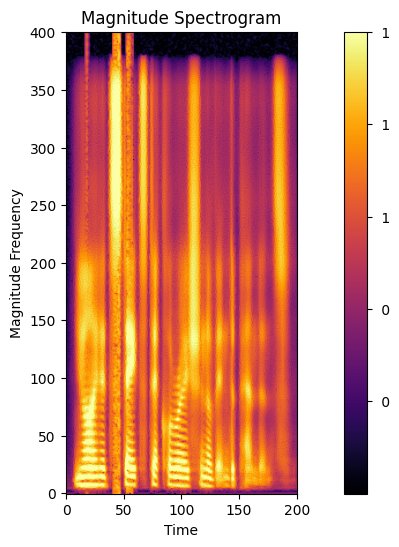

In [90]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

# Plot the Mel spectrogram
plt.figure(figsize=(12, 6))
plt.imshow(mag, cmap='inferno', origin='lower')
plt.xlabel('Time')
plt.ylabel('Magnitude Frequency')
plt.title('Magnitude Spectrogram')
plt.colorbar(format='%2.0f')
plt.savefig('/kaggle/working/actual_magnitude.png', dpi=300, bbox_inches='tight')
plt.show()

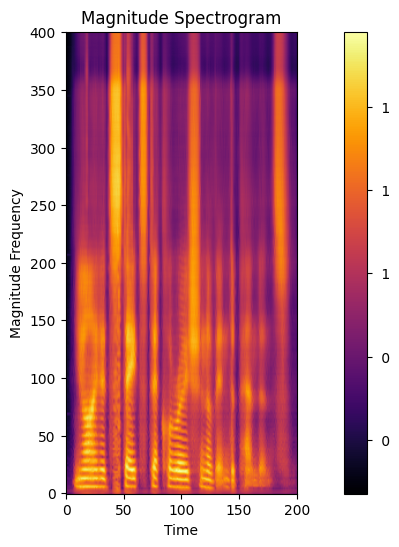

In [91]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

# Plot the Mel spectrogram
plt.figure(figsize=(12, 6))
plt.imshow(pred_mag.detach().cpu().numpy()[0].T, cmap='inferno', origin='lower')
plt.xlabel('Time')
plt.ylabel('Magnitude Frequency')
plt.title('Magnitude Spectrogram')
plt.colorbar(format='%2.0f')
plt.savefig('/kaggle/working//pred_magnitude.png', dpi=300, bbox_inches='tight')
plt.show()

In [92]:
audio = generate_audio(pred_mag.detach().cpu().numpy()[0].T)

In [70]:
audio.shape

(220800,)

In [71]:
sf.write("/kaggle/working/generated_audio.wav", audio, 16000)

In [187]:
mag.shape

(1025, 277)

In [198]:
audio = T2S_GEN.magnitude_db_to_audio_using_griffin(mag)
audio = librosa.effects.time_stretch(audio, rate=2)
audio *= 6
sf.write("/kaggle/working/griffin_generated_audio_x2_speed.wav", audio, 16000)

In [199]:
audio.shape

(70656,)

In [96]:
audio = T2S_GEN.magnitude_db_to_audio_using_griffin(pred_mag.detach().cpu().numpy()[0].T)
audio *= 6
sf.write("/kaggle/working/griffin_pred_mag_generated_audio.wav", audio, 16000)

In [95]:
audio = T2S_GEN.magnitude_db_to_audio(pred_mag.detach().cpu().numpy()[0].T)
audio *= 6
sf.write("/kaggle/working/generated_audio.wav", audio, 16000)
audio.shape

(40000,)

In [94]:
audio = T2S_GEN.mel_to_audio(mel)
audio *= 6
sf.write("/kaggle/working/mel_generated_audio.wav", audio, 16000)

In [162]:
audio.shape

(55200,)